In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from numba import njit, jit, prange
from img2vec import get_features
from distances import cosine_distance
import pickle
import random
from pathlib import Path

In [3]:
with open("data/landscapes_features.pkl", "rb") as f:
    all_files = pickle.load(f)

print("Loaded %i feature vectors" % len(all_files))
for entry in all_files:
    for key in entry["features"]:
        entry["features"][key] = entry["features"][key] / np.linalg.norm(
            entry["features"][key])

all_test_files = glob("../landscapes/test/*/*.jpeg")
random.shuffle(all_test_files)

print(f"Testing {len(all_test_files)} images")

Loaded 10000 feature vectors
Testing 500 images


In [7]:
classes = ["coast", "desert", "forest", "mountain", "glacier"]

In [9]:
y_true = []
y_pred = []

for entry in all_test_files:
  query = cv2.imread(entry)
  query_f = get_features(query)
  query_features = np.concatenate([(query_f[key]) / np.linalg.norm(query_f[key]) for key in query_f])

  distances = []
  for db_img in all_files:
      df = np.concatenate([
          db_img["features"][key] for key in db_img["features"]
      ])
      distances.append({
          "name": db_img["filename"],
          "class":  classes.index(db_img["class"]),
          "distance": cosine_distance(query_features, df)
      })
  distances = sorted(distances, key=lambda x: x["distance"], reverse=False)
  selfClass = Path(entry).parent.name.lower()
  selfClass = classes.index(selfClass)
  # predict class from top 5 results
  top10 = [x["class"] for x in distances[:5]]
  if len(top10) == 0:
    continue
  predictedClass = max(set(top10), key=top10.count)
  if predictedClass == selfClass:
    print(f"PASS {Path(entry).name} - {classes[predictedClass]} - {top10.count(predictedClass)/len(top10)}")
  else:
    print(f"FAIL {Path(entry).name} - {classes[predictedClass]} - {top10.count(predictedClass)/len(top10)}")
  y_true.append(selfClass)
  y_pred.append(predictedClass)

FAIL Desert-Test (44).jpeg - coast - 0.6
PASS Coast-Test (126).jpeg - coast - 0.4
PASS Coast-Test (114).jpeg - coast - 1.0
FAIL Forest-Test (23).jpeg - mountain - 0.6
PASS Coast-Test (170).jpeg - coast - 0.6
PASS Coast-Test (157).jpeg - coast - 0.6
PASS Glacier (399).jpeg - glacier - 1.0
PASS Coast-Test (93).jpeg - coast - 1.0
PASS Coast-Test (91).jpeg - coast - 0.6
PASS Coast-Test (181).jpeg - coast - 0.8
FAIL Mountain-Test (32).jpeg - glacier - 1.0
FAIL Forest-Test (4).jpeg - mountain - 0.8
PASS Desert-Test (94).jpeg - desert - 1.0
PASS Glacier (307).jpeg - glacier - 0.8
PASS Desert-Test (76).jpeg - desert - 0.8
PASS Glacier (364).jpeg - glacier - 1.0
PASS Coast-Test (118).jpeg - coast - 1.0
PASS Desert-Test (29).jpeg - desert - 0.8
PASS Coast-Test (171).jpeg - coast - 0.4
PASS Forest-Test (62).jpeg - forest - 1.0
PASS Forest-Test (95).jpeg - forest - 1.0
PASS Glacier (356).jpeg - glacier - 1.0
PASS Coast-Test (119).jpeg - coast - 0.8
FAIL Forest-Test (54).jpeg - coast - 0.6
PASS Des

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [12]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
print(f"F1: {f1_score(y_true, y_pred, average='macro')}")

Accuracy: 0.718
Precision: 0.7269867565630275
Recall: 0.718
F1: 0.7101406024893139


<AxesSubplot: >

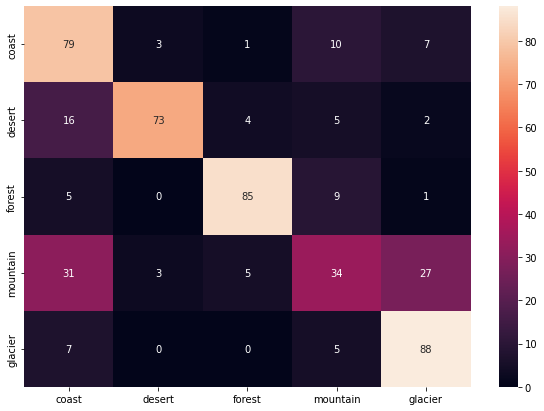

In [11]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")